In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
#
from scipy import stats

import matplotlib.pyplot as plt
import tikzplotlib
import os

In [2]:
prec = 4
results_filename = "results630.json"

In [3]:
with open('models/metadata.json', 'r') as file:
    metadata = json.load(file)
    
with open(os.path.join('optimization', results_filename), 'r') as file:
    results = json.load(file)

In [4]:
methods = ['slsqp', 'cobyqa', 'pdfo']
losses_dict = {method: [result[method]['loss'] for result in results] for method in methods}
times_dict = {method: [result[method]['time'] for result in results] for method in methods}
c_violation_dict = {method: [result[method]['c_violation'] for result in results] for method in methods}
#deviations_dict = {method: [np.sum(result[method]['x_min'])-5*m for result in results] for method in methods}
x_min_dict = {method: [result[method]['x_min'] for result in results] for method in methods}

In [5]:
# change the key from 'cobyqa' to 'COBYQA', and 'ann' to 'SLSQP'
new_keys = ['SLSQP','COBYQA', 'COBYLA']
new_losses_dict = dict(zip(new_keys, losses_dict.values()))
new_times_dict = dict(zip(new_keys, times_dict.values()))
new_c_volation_dict = dict(zip(new_keys, c_violation_dict.values()))
new_x_min_dict = dict(zip(new_keys, x_min_dict.values()))

In [6]:
print("ANN:", round(metadata['ANN_R2'],prec))
print("XGB:", round(metadata['XGB_R2'],prec))

print("\nNumber of trials:", len(results))
#
print("\nMean losses:")
for method in methods:
    print(f"{round(np.mean(losses_dict[method]),prec)}: {method}")
#
print("\nMean processing times:")
for method in methods:
    print(f"{round(np.mean(times_dict[method]),prec)}: {method}")
#
# print("\nMean deviations from constraint:")
# for method in methods:
#     deviations = [np.abs(np.sum(x_min)-5*m) for x_min in x_min_dict[method]]
#     mean_deviation = np.mean(deviations)
#     print(f"{round(100*mean_deviation/(5*m),prec)}%: {method}")
#
print("\nOut-of-bounds errors:")
boundary_error_list = [method for method in methods if np.min(x_min_dict[method])<0 or np.max(x_min_dict[method])>1000]
print(boundary_error_list or "None.")

ANN: -406.9107
XGB: 0.5674

Number of trials: 600

Mean losses:
4430.6569: slsqp
4437.8153: cobyqa
4494.9615: pdfo

Mean processing times:
15.7306: slsqp
491.7871: cobyqa
58.999: pdfo

Out-of-bounds errors:
['cobyqa', 'pdfo']


# Plots

In [7]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':300, 
                     'lines.markersize': 4, 'lines.markeredgecolor': 'k', 'lines.marker': 'o',
                     'font.size': 16, 'legend.fontsize': 15,})

AttributeError: 'Legend' object has no attribute '_ncol'

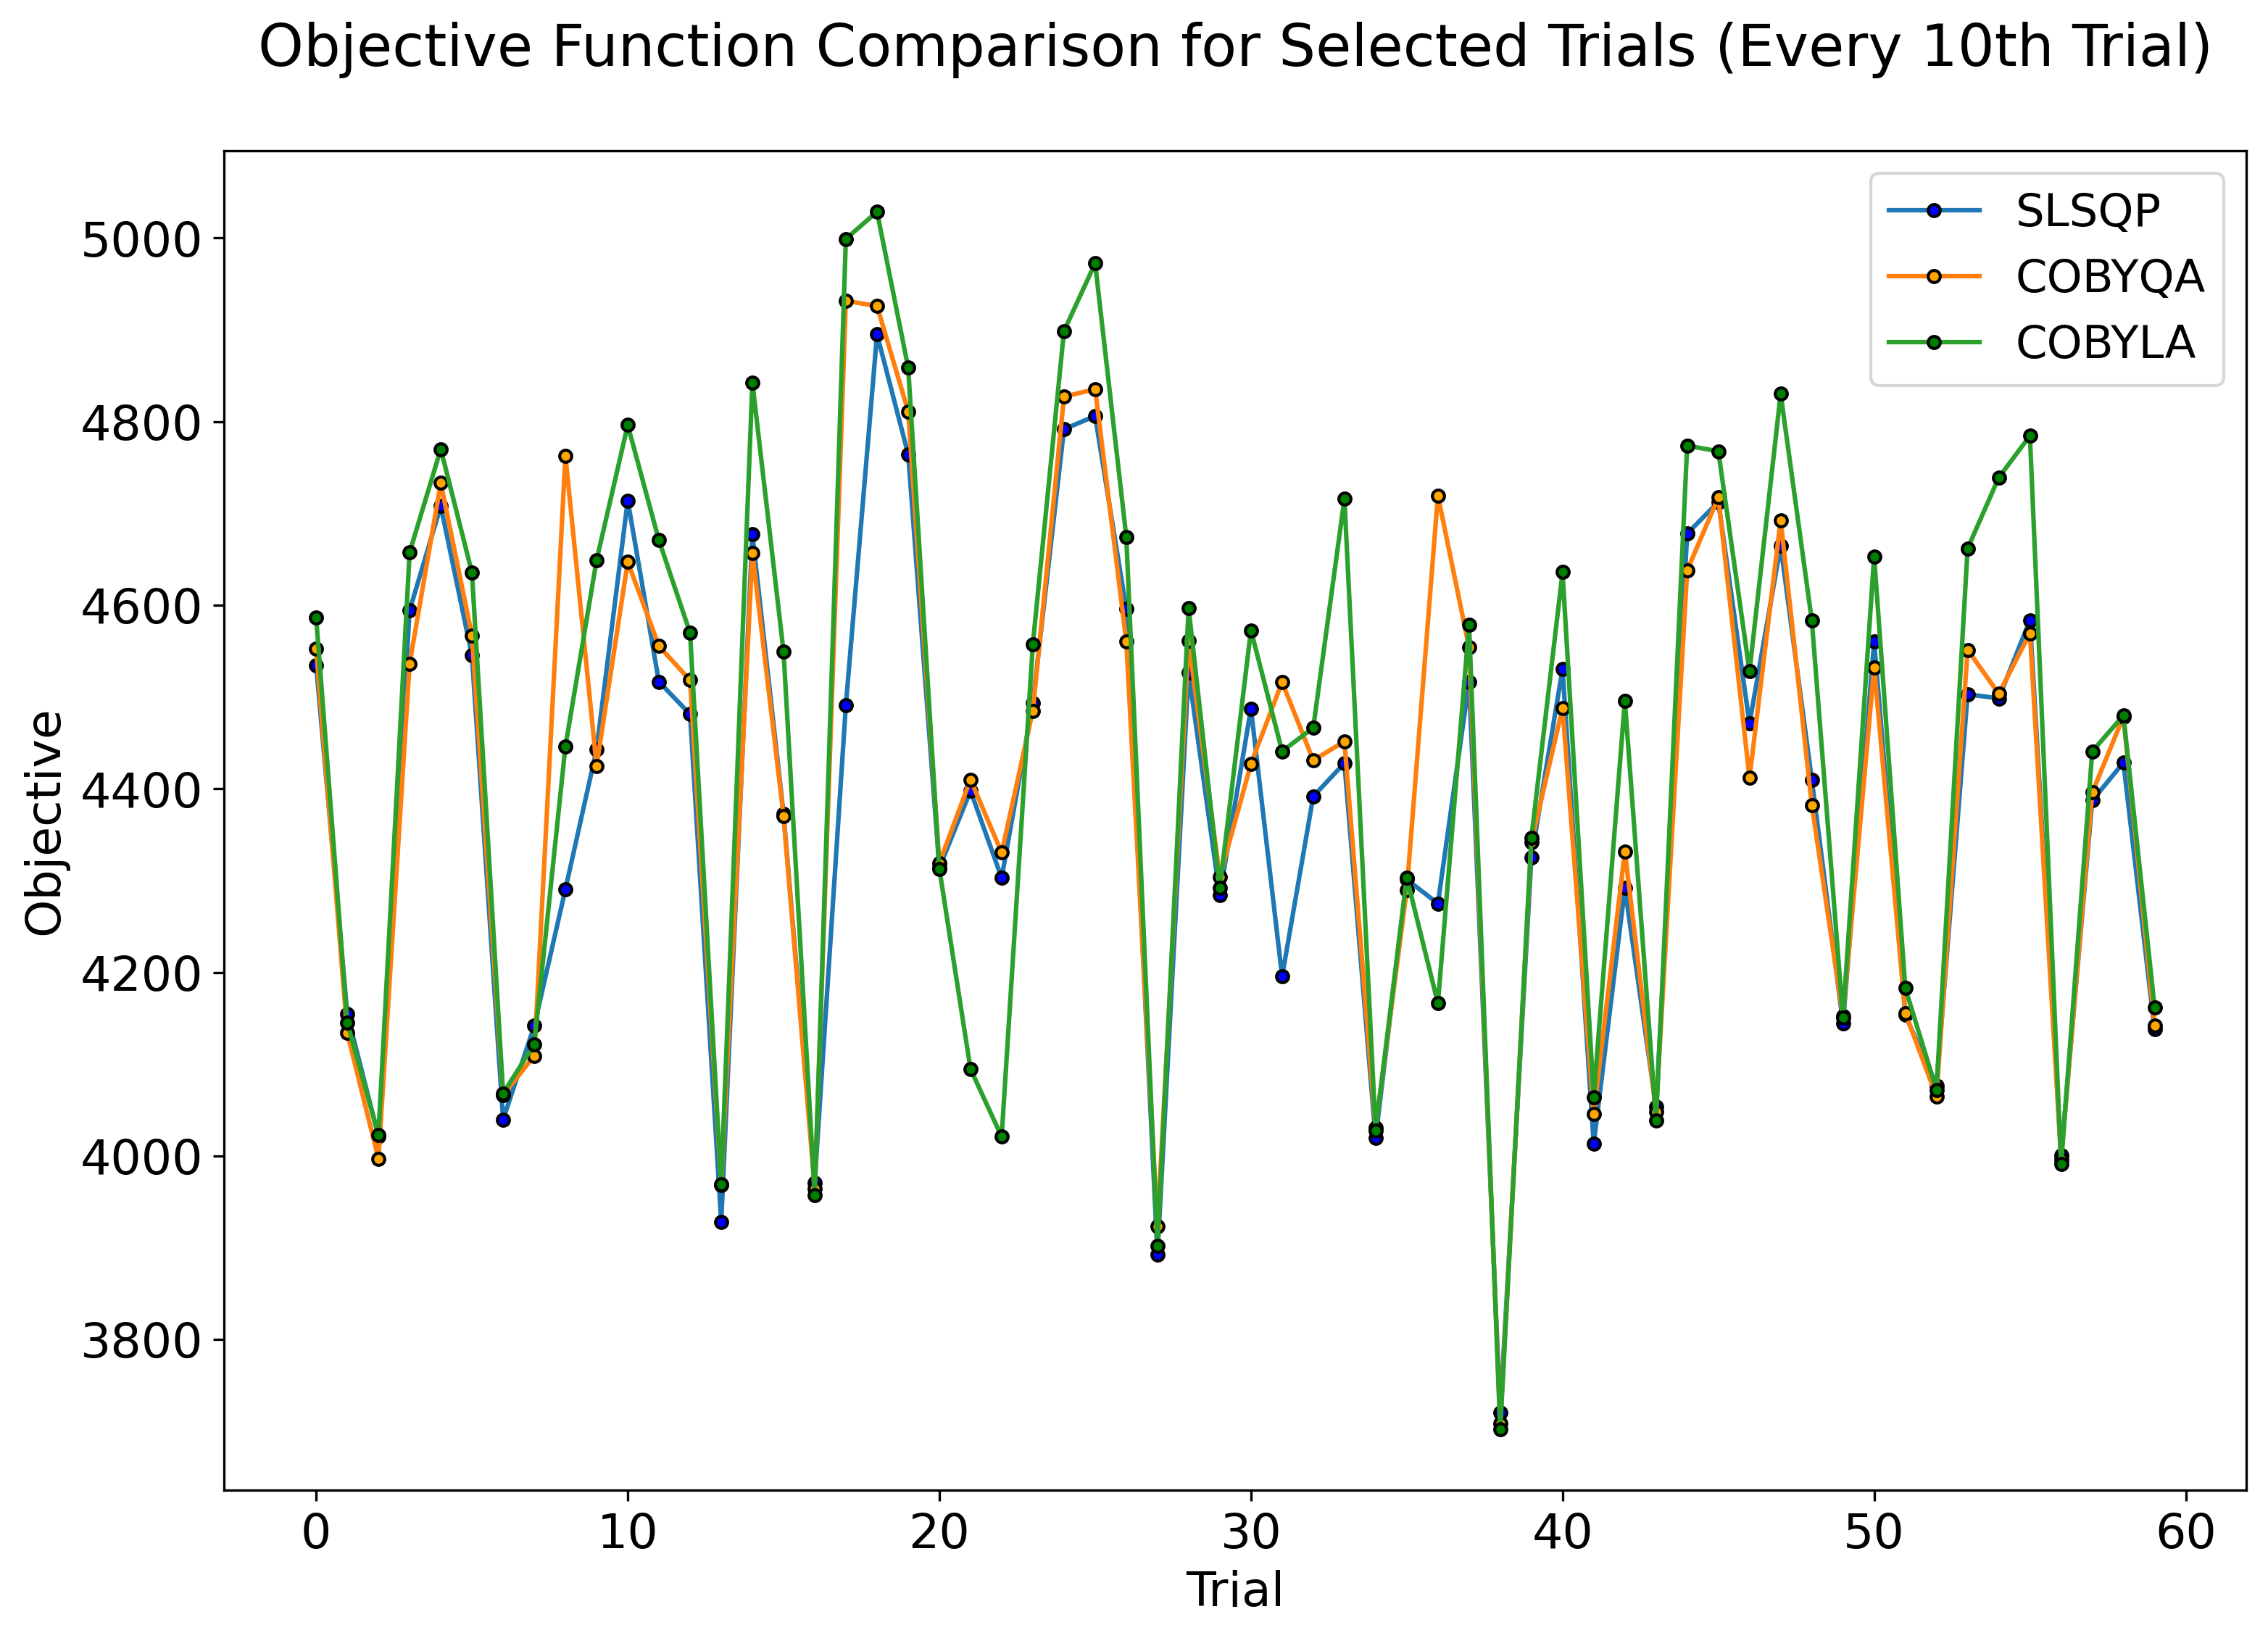

In [8]:
colors = ['blue', 'orange', 'green']

def line_scatter_plot(losses_dict, methods, num_trials=60, step=10):
    _,ax = plt.subplots(1,1)
    for color, method in zip(colors, methods):
        reduced_losses = losses_dict[method][::step][:num_trials]
        ax.plot(reduced_losses,  markerfacecolor=color, label=method)
    ax.legend()
    ax.set_title(f"Objective Function Comparison for Selected Trials (Every 10th Trial)", y=1.05)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Objective")

line_scatter_plot(new_losses_dict, new_keys)  


tikzplotlib.save(f"fig_tex/foundry_losses.tex")

In [9]:
def box_plot(box_data, methods, title, ylabel):
    df_box = pd.DataFrame({method: box_data[method] for method in methods})
    _,ax = plt.subplots(1,1)
    s_box = sns.boxplot(x="variable", y="value", data=pd.melt(df_box), width=0.5)
    ax.set_title(title, y=1.05)
    ax.set_xlabel("Method")
    ax.set_ylabel(ylabel)

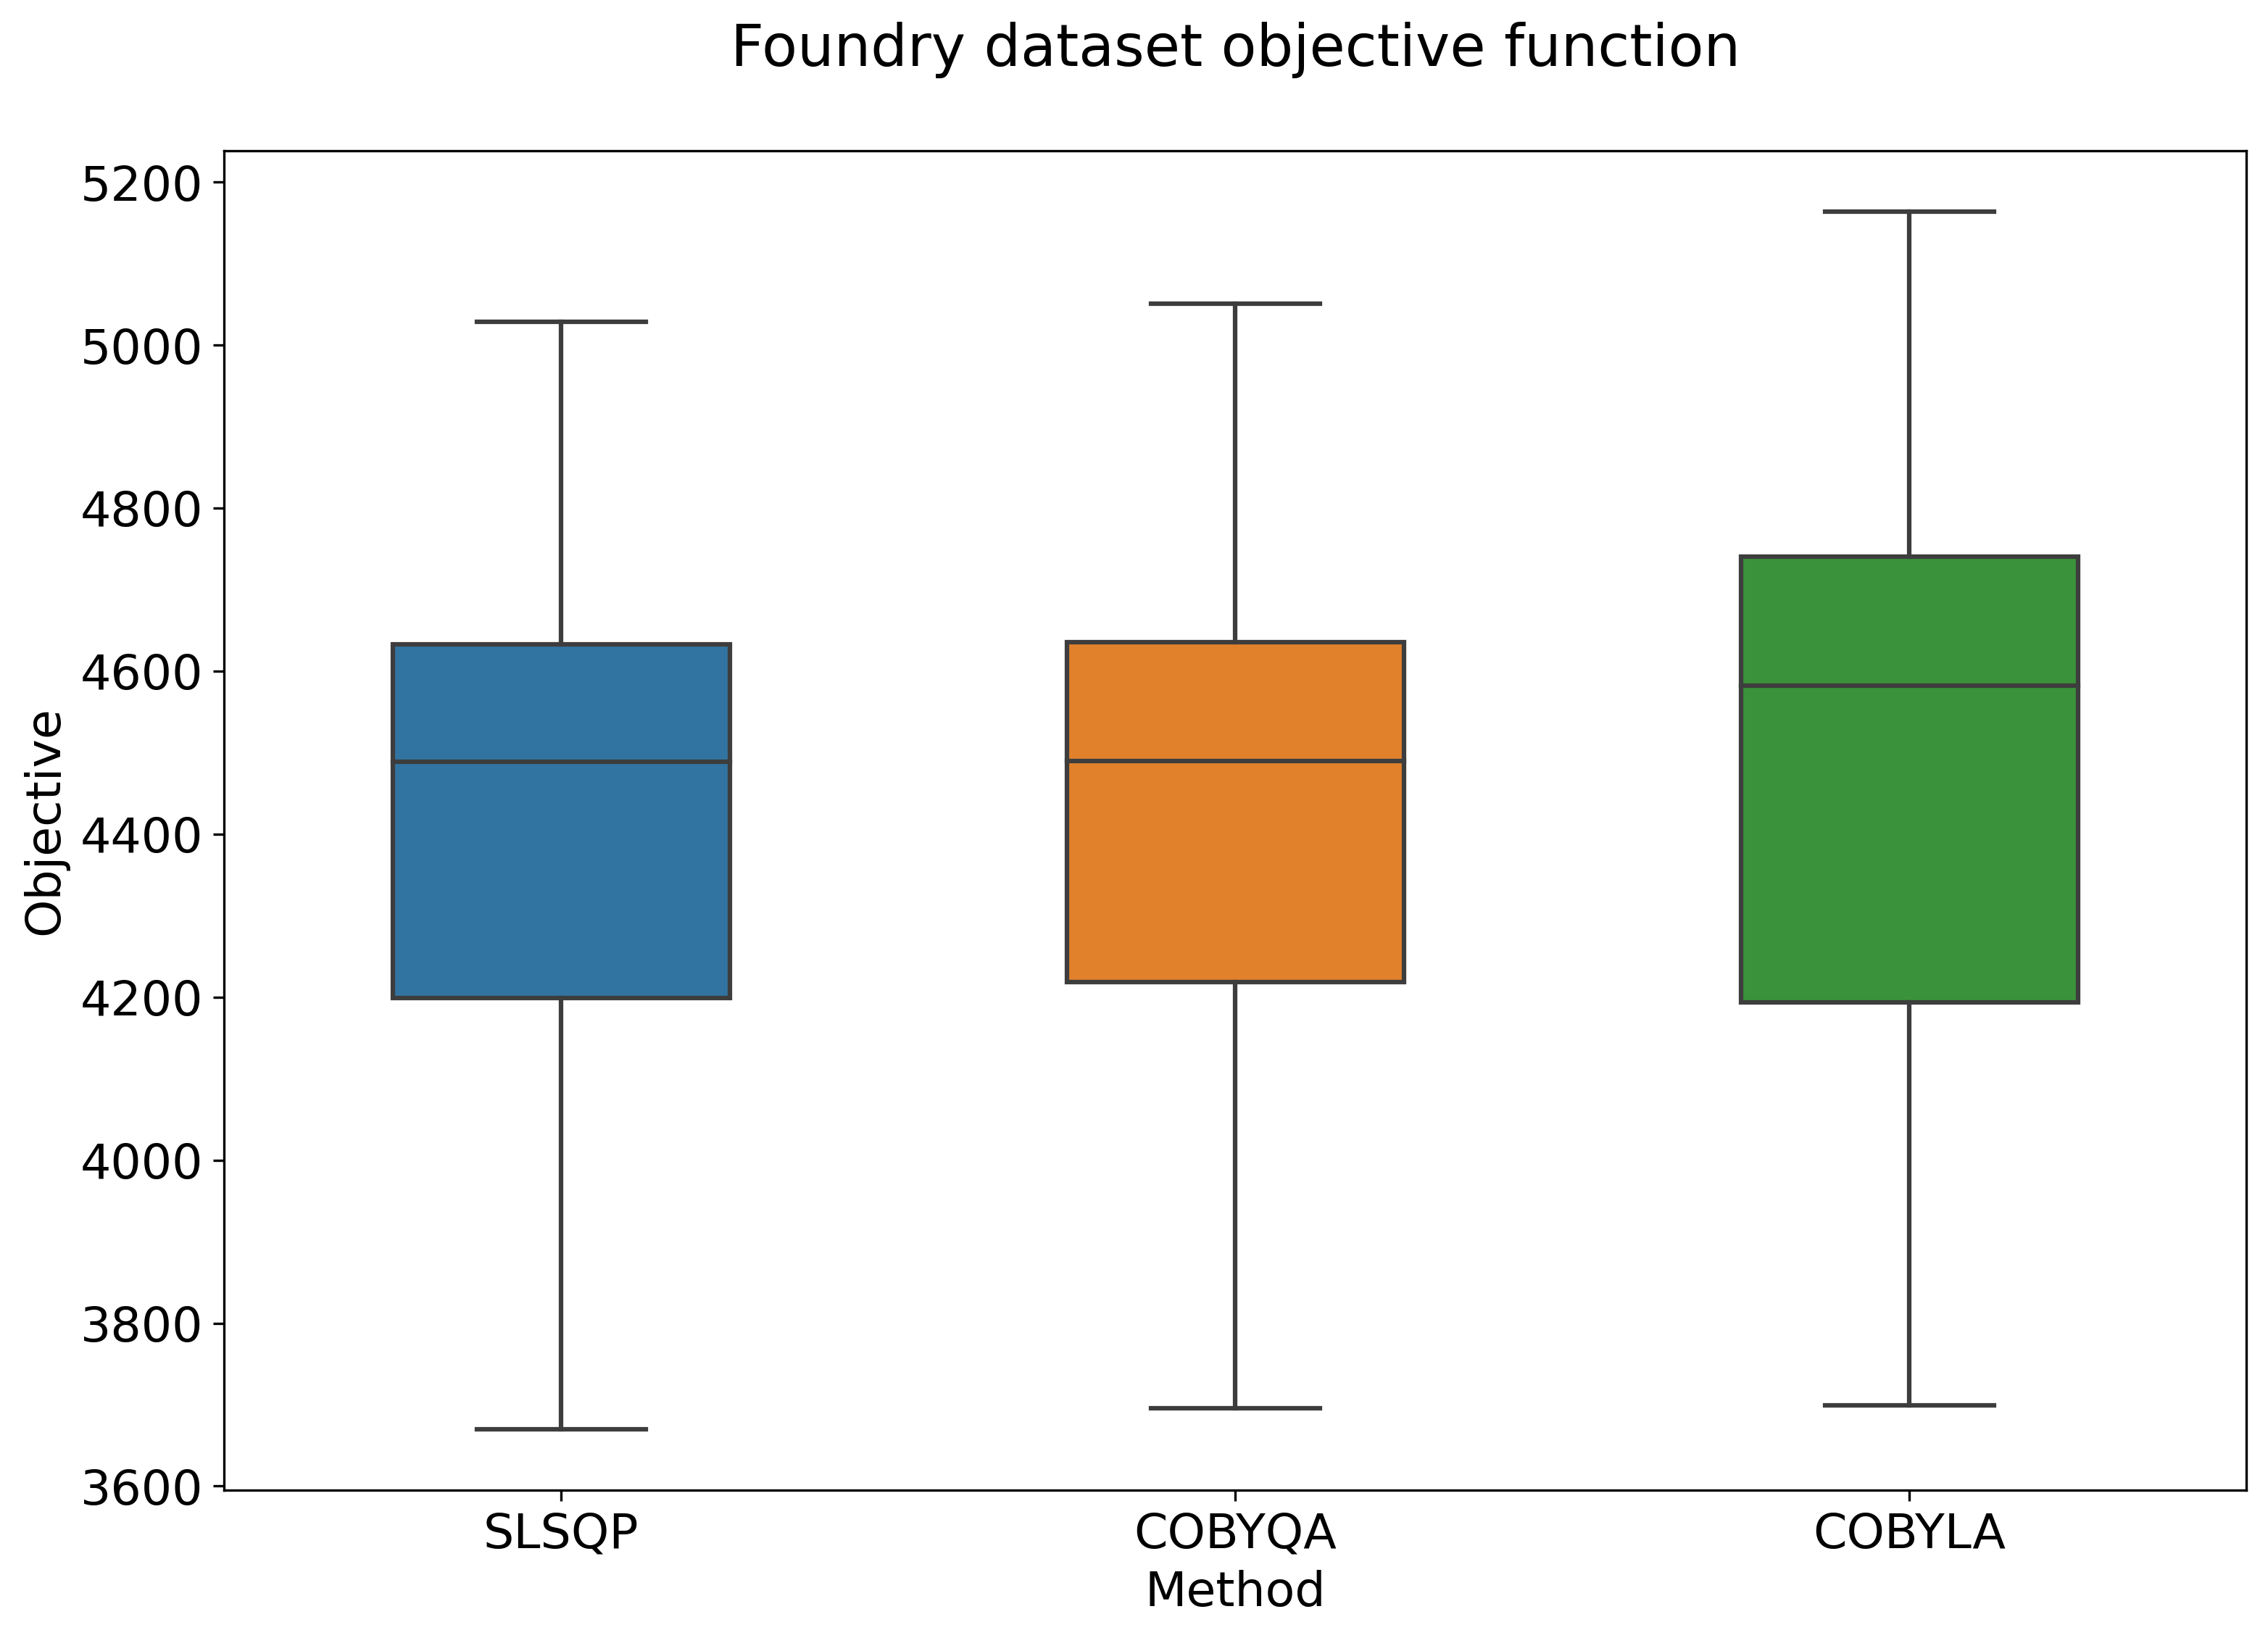

In [10]:
box_plot(new_losses_dict, new_keys, "Foundry dataset objective function", "Objective")
tikzplotlib.save(f"fig_tex/foundry_boxplot_losses.tex")

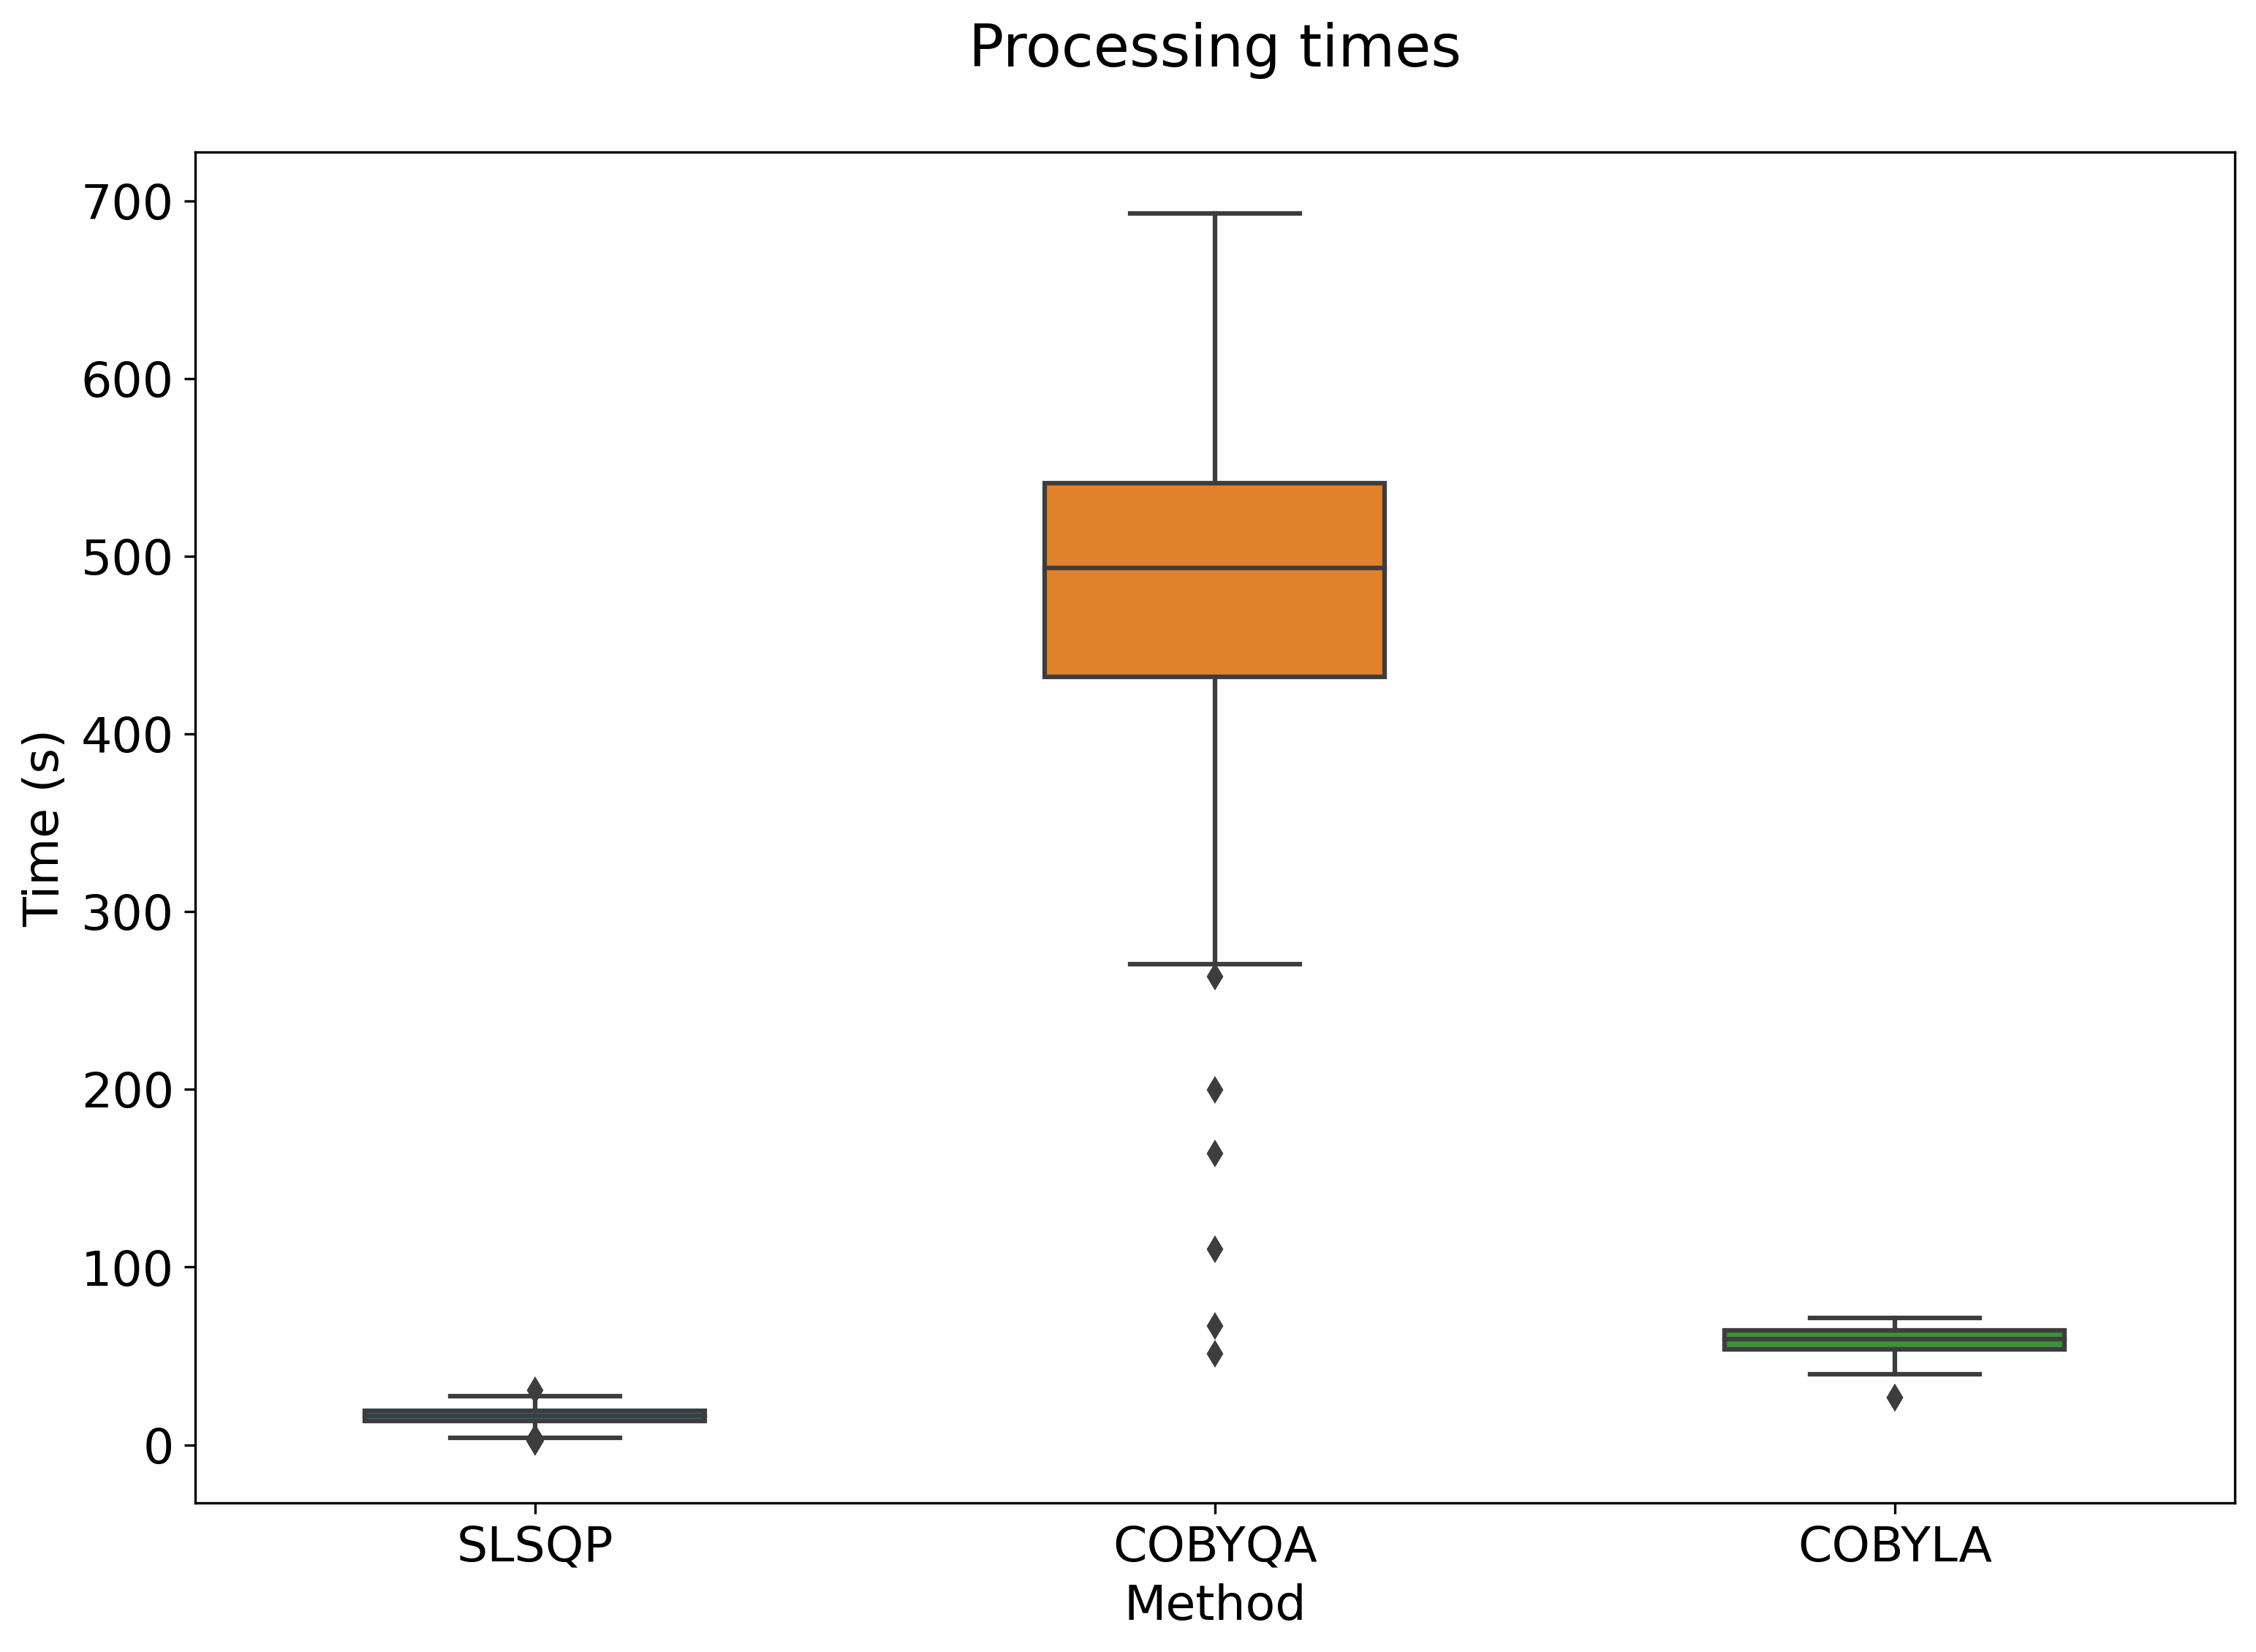

In [11]:
box_plot(new_times_dict, new_keys, "Processing times", "Time (s)")
tikzplotlib.save(f"fig_tex/foundry_boxplot_times.tex")

In [12]:
colors = ["C1","C2"]

def box_plot_2(box_data, methods, title, ylabel):
    df_box = pd.DataFrame({method: box_data[method] for method in methods})
    _,ax = plt.subplots(1,1)
    s_box = sns.boxplot(x="variable", y="value", data=pd.melt(df_box), width=0.5, palette=colors)
    ax.set_title(title, y=1.05)
    ax.set_xlabel("Method")
    ax.set_ylabel(ylabel)


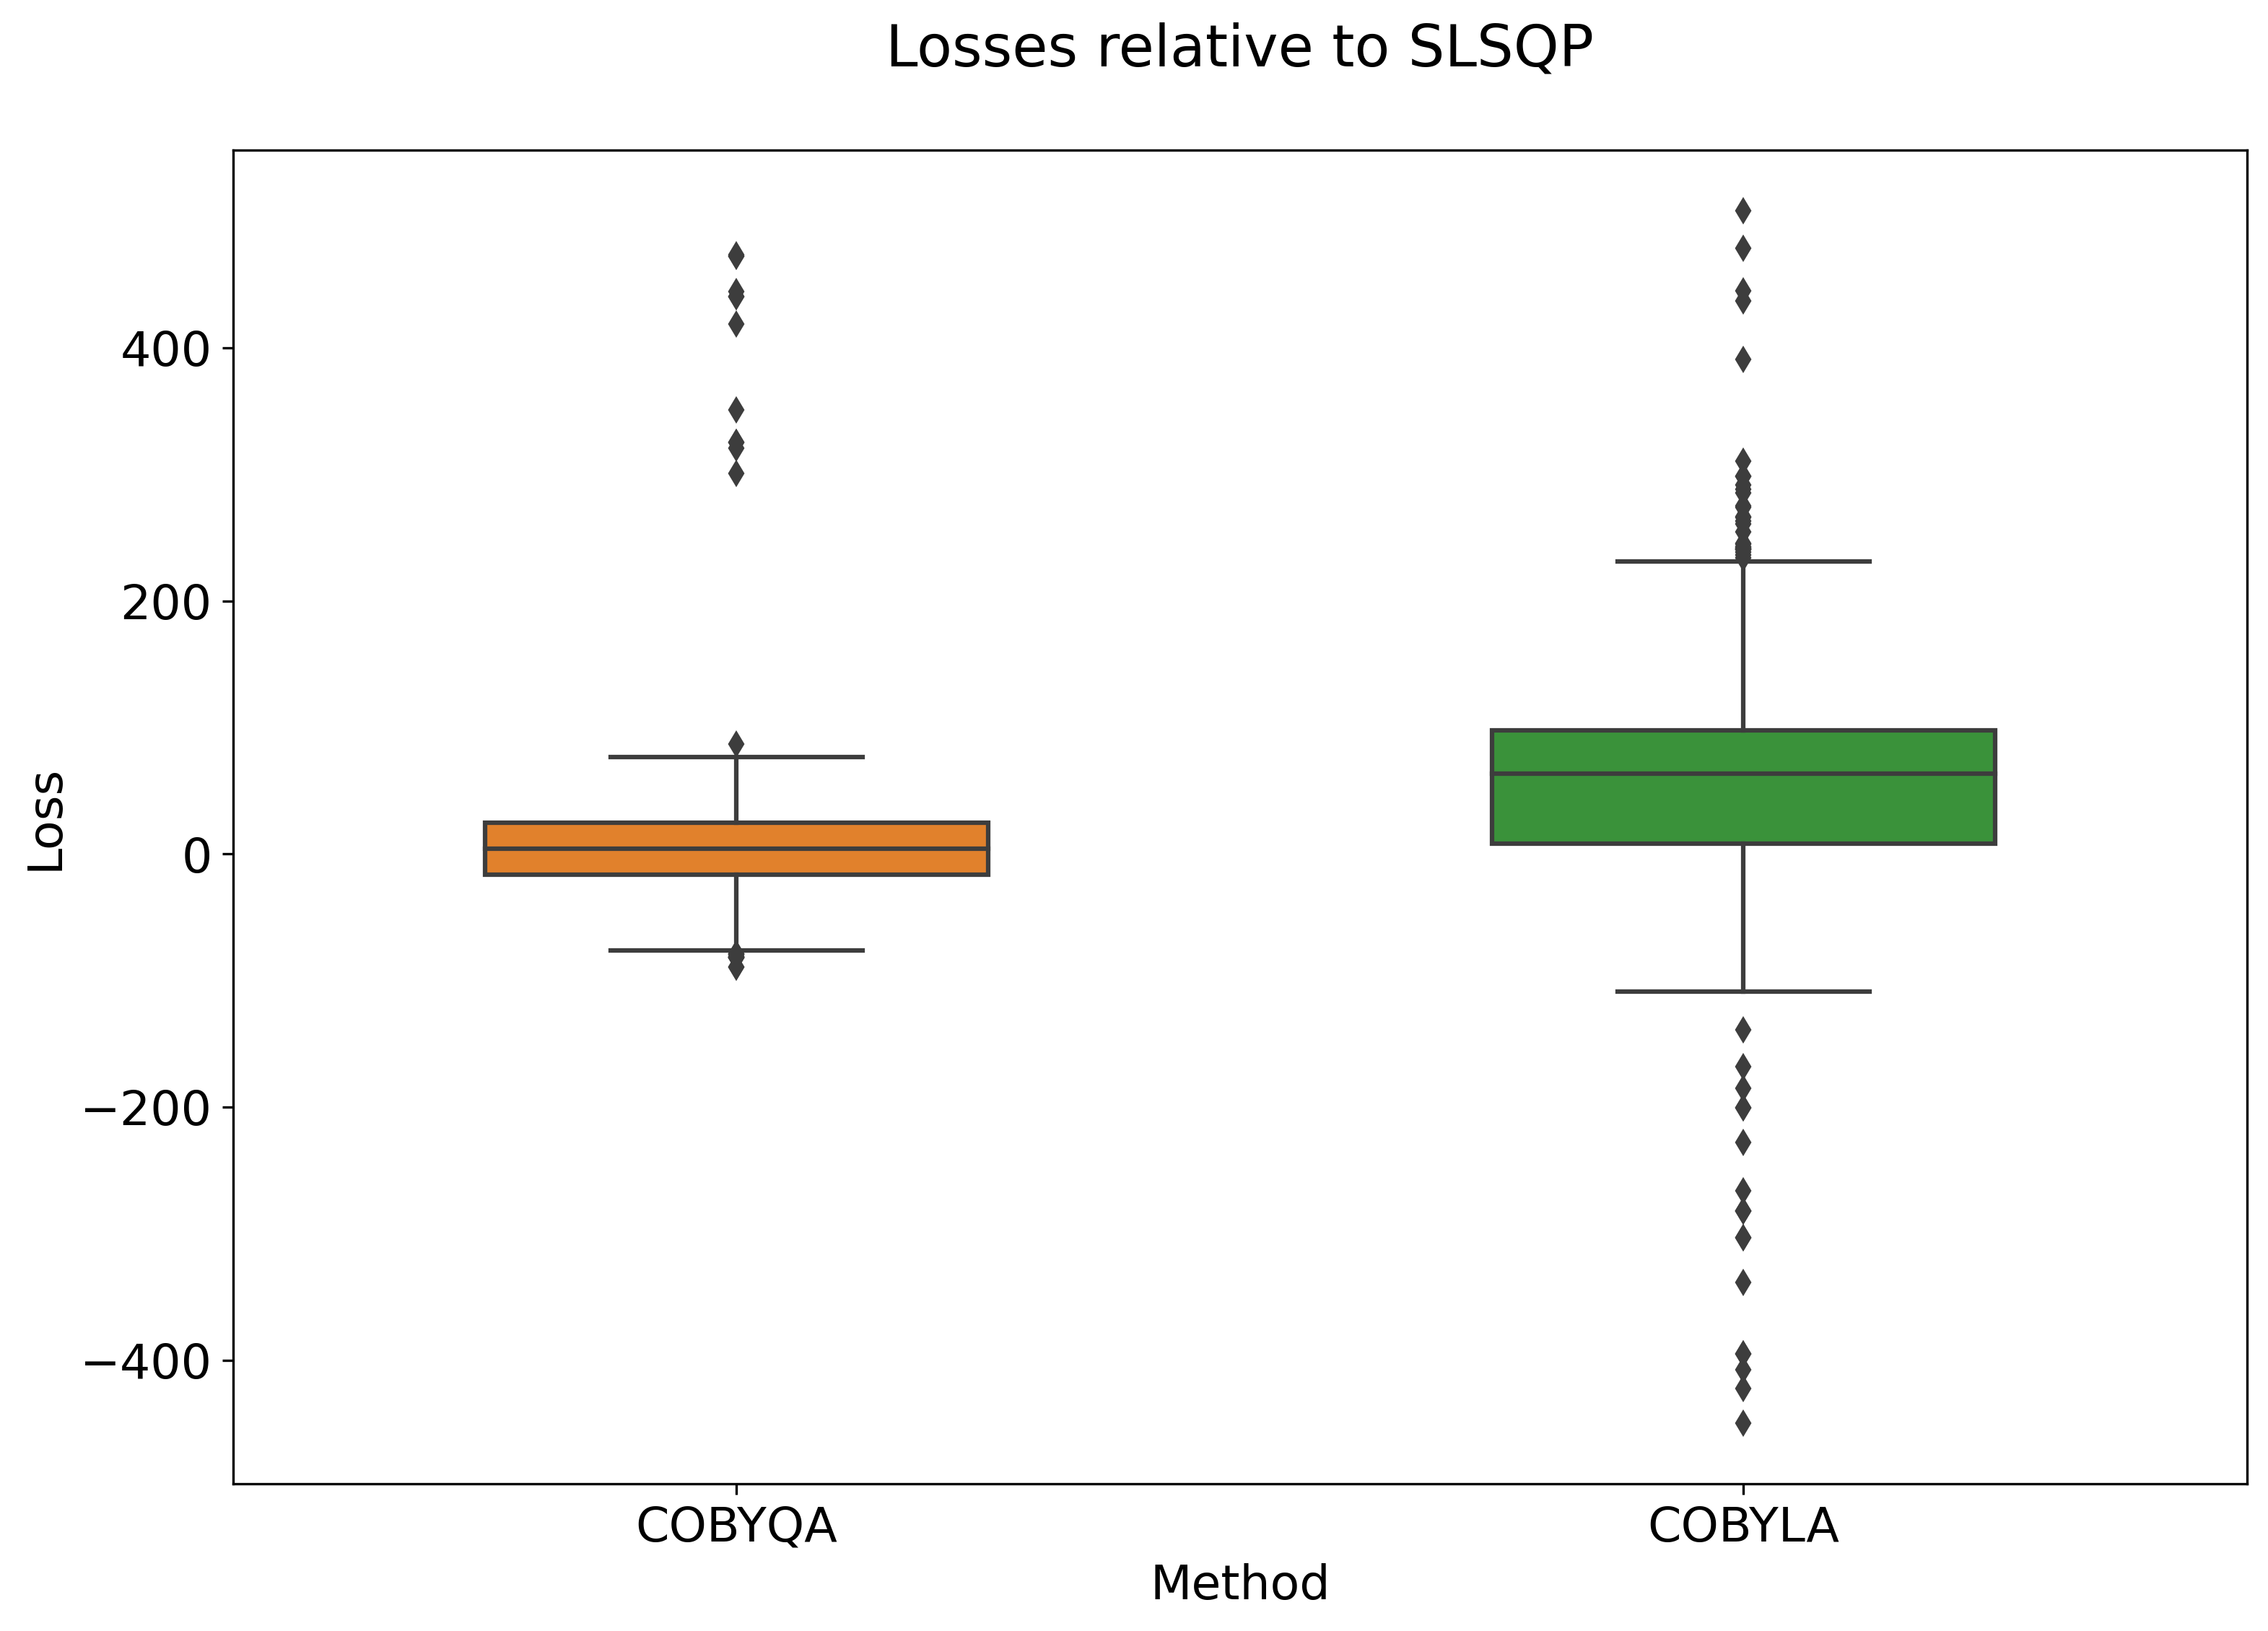

In [13]:
ng_methods = ['COBYQA', 'COBYLA']
boxplot_data_ng = [np.array(new_losses_dict[method])-np.array(new_losses_dict['SLSQP']) for method in ng_methods]
# use a dictionary to map the method names the boxplot_data_ng list
boxplot_data_dict = {method: boxplot_data_ng[i] for i, method in enumerate(ng_methods)}
box_plot_2(boxplot_data_dict, ng_methods, "Losses relative to SLSQP", "Loss")
tikzplotlib.save(f"fig_tex/foundry_compare_to_ann.tex")

In [7]:
# constraints deviation
pdfo_c_violation = np.mean(np.abs([results[i]['pdfo']['c_violation'] for i in range(len(results))]), axis=0)

slsqp_c_violation = np.mean(np.abs([results[i]['slsqp']['c_violation'] for i in range(len(results))]), axis=0)

beq_mean = np.mean([results[i]['beq'] for i in range(len(results))], axis=0)

In [8]:
np.mean(pdfo_c_violation / beq_mean, axis=0)

0.009982126477979058

In [9]:
np.mean(slsqp_c_violation / beq_mean, axis=0)

0.0029193681143363796

In [15]:
print("Two-sided t-test for equality of means between ANN and...")
for method in ['pdfo', 'cobyqa']:
    print(f"{method}: {stats.ttest_rel(losses_dict['slsqp'], losses_dict[method]).pvalue}")

Two-sided t-test for equality of means between ANN and...
pdfo: 7.037087456077594e-45
cobyqa: 0.0076862198849819525
